In [196]:
using DelimitedFiles
using LinearAlgebra
using Plots
using Base.Threads, MKL
using Interpolations
using  ForwardDiff

In [197]:
#### Here using the density and the local currents the Electric field is calculated using the Jeff eqs. 

In [511]:
a = 1# Amstrong 10^-10 m in Amstrong*1e-10 ### This is the distance between the lattice points
L_s =10*a
c   = 2.99792458*1e3# Am/fs #2.99792458*1e8 ### m/s light velocity
#ke = 8.9875517923*1e9 # Jm/C^2
#e = 1.602e-19 # electron charge in C
ke = 14.399645478 # units of eV Am /e^2
hbar = 0.658211928e0 
h = hbar*2*pi #eV fs
t_r = a/c ## distance to travel one lattice point
n_lattice =10
Nint = 300 ;
const1 = 1
const2 = 1
const3 = 1

1

In [489]:
#8.9875517923*1.602176634


In [490]:
name1="Ni_soc"
n = readdlm("/home/jalil/Projects2023/TDNEGF/git_temp/TDNEGF/data/cden_$(name1)_jl.txt")
bcurr = readdlm("/home/jalil/Projects2023/TDNEGF/git_temp/TDNEGF/data/bcurr_$(name1)_jl.txt")

54000×37 Matrix{Float64}:
    0.0   0.0227847     8.89917e-5   …  -4.0279e-8    -1.72361e-5
    0.1   0.173012      0.00273866      -4.78117e-6   -0.000506708
    0.2   0.537027      0.0195334       -7.55869e-5   -0.0035077
    0.3   1.13404       0.075492        -0.0005174    -0.0132282
    0.4   1.9106        0.206244        -0.00221814   -0.0353278
    0.5   2.75648       0.44826      …  -0.00701827   -0.075056
    0.6   3.5366        0.825268        -0.0178834    -0.134893
    0.7   4.12919       1.33574         -0.0386491    -0.212599
    0.8   4.45877       1.94641         -0.0732239    -0.300509
    0.9   4.51452       2.59495         -0.124345     -0.386516
    1.0   4.34955       3.2021       …  -0.192201     -0.456633
    1.1   4.0621        3.6902          -0.273385     -0.49845
    1.2   3.76545       4.00287         -0.360621     -0.504473
    ⋮                                ⋱   ⋮            
 5398.8   8.15475e-12   4.96323e-13      1.91652e-10  -1.38879e-10
 5398.9  -1.2

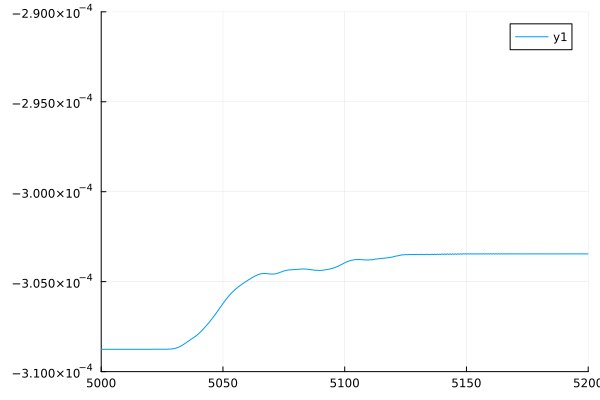

In [491]:
plot(n[:,1], n[:,2], ylims = ( -30e-5-1e-5,-30e-5+1e-5), xlims = (5000,5200)  )
#plot!(n[:,1], n[:,3], ylims = ( -30e-5-1e-5,-30e-5+1e-5), xlims = (5000,5200)  )

#n[:,2]

In [492]:
### Interpolation of the function and its derivate
itp = LinearInterpolation(n[:,1], n[:,2])
d_itp(t)=ForwardDiff.derivative(itp,t)

d_itp (generic function with 1 method)

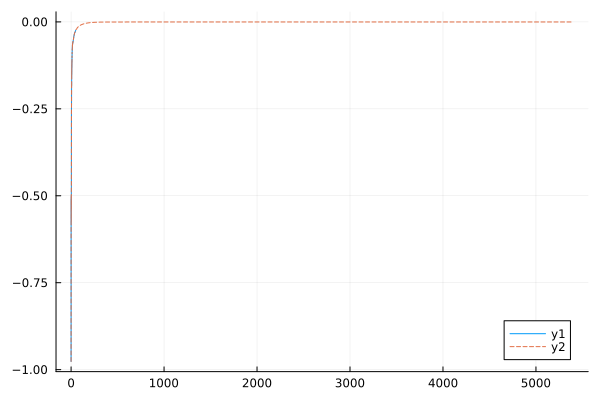

In [558]:
### Check that the interpolation method is working!
ts = 0:0.2:50 
plot(ts,itp.(ts))
plot!(n[:,1], n[:,2] , linestyle = :dash)

In [494]:
n[:,1+1]#[5000+1,5299]

54000-element Vector{Float64}:
 -0.9764173135341845
 -0.9109726708937389
 -0.8174640561607006
 -0.7143639835362151
 -0.6202681297602626
 -0.5495933705308771
 -0.5096432067558887
 -0.4997212852446543
 -0.5123696189180218
 -0.5362171243441047
 -0.5595167232072176
 -0.5733331017182588
 -0.5735337069312221
  ⋮
 -0.00030345687619770523
 -0.00030345687085692186
 -0.0003034568758067402
 -0.00030345687093064067
 -0.00030345687523108955
 -0.0003034568713097263
 -0.0003034568747699029
 -0.000303456872074781
 -0.00030345687436533764
 -0.00030345687292465673
 -0.0003034568737353971
 -0.00030345687355504136

In [495]:
#bc_currs = bcurr[:,1:10]
bc_currs_funcs = []
dt_bc_currs_funcs = []
### Here we use only what we need 400 points
for i in range(1,n_lattice-1)
    f = LinearInterpolation(bcurr[:,1][1:4000], bcurr[:,1+i][50000+1:54000])
    push!(bc_currs_funcs, f  )
    d_f(t)=ForwardDiff.derivative(f,t)
    push!(dt_bc_currs_funcs,d_f )
end
cden_funcs = []
dt_cden_funcs = []
for i in range(1,n_lattice)
    f = LinearInterpolation(n[:,1][1:4000], n[:,1+i][50000+1:54000])
    push!(cden_funcs, f )
    d_f(t)=ForwardDiff.derivative(f,t)
    push!(dt_cden_funcs,d_f )
end

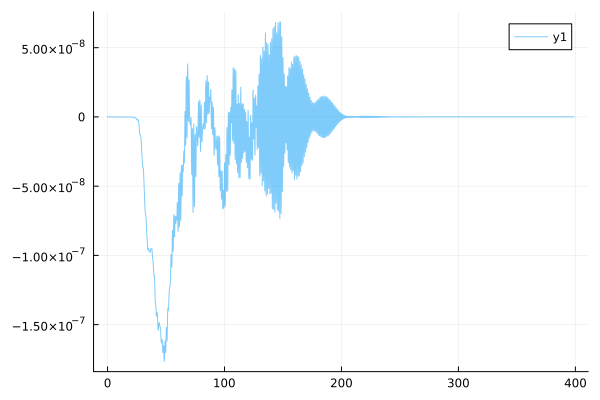

In [496]:
#dt_cden_funcs[3](3.4)

tss = 0.0:0.1:399
#plot(tss,cden_funcs[9].(tss))
plot(tss,dt_cden_funcs[9].(tss),alpha =0.5)
#plot!(tss,cden_funcs[5].(tss))

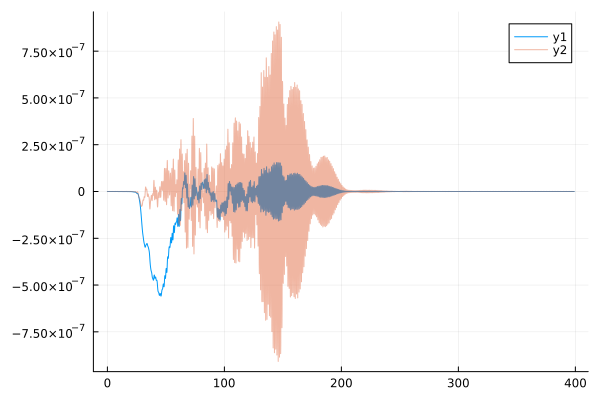

In [497]:
tss = 0.0:0.1:399

plot(tss,bc_currs_funcs[1].(tss))

plot!(tss,dt_bc_currs_funcs[1].(tss),alpha=0.5)

#plot!(tss,cden_funcs[5].(tss))

In [498]:
### Nottice that we will assume that our coordinate system is in the site 1 of the central system


function pos(j)
    ex = [1 , 0 , 0]
    
    return ex*a*j
end

function Jeff_Efield(r=[1,2,3], n = cden_funcs, dn = dt_cden_funcs, dI = dt_bc_currs_funcs ; t=0.1 )
    """ This function calculates the electric field produced by the Jeff eq. 
    """
    E = zeros(3)
    ##println(0)
    #for tt in range(ti,tf) ### range of times where the Electric field is calculated
    for j in range(1,n_lattice) ### l is the number of lattice points considered
        ##println(j)
        rn = pos(j) ### pos contain all the position of the lattice in a vector format
        ### Derivate and local density 
        tt = t - norm(r-rn)/c
        E += const1*n[j](tt)*(r-rn)/norm(r-rn)^3
        E += const2*dn[j](tt)*(r-rn)/norm(r-rn)^2
    end
    ##println(0)
    for  i in range(1, n_lattice-1)  ## Run over the number of bounds of the system
        ### Notice that only NN are considered
        ##println(i)
        j = i+1
        r1 = pos(i)
        r2 = pos(j)
        #dt = 1/Nint
        dl = (r2-r1)/Nint
        val = zeros(3)
        ##println(dl)
        for n_l in range(1,Nint)
            l = r1 + dl*n_l
            tt = t - norm(r-l)/c
            val = val + const3*dI[i](tt)*dl/norm(r-l) 
            ##println(dI[i](tt) , dl)
        end
        E += val #const3*dI[tt,i]*val
    end       
    #end
    return E

end

Jeff_Efield (generic function with 6 methods)

In [499]:
function E_dtJ(dI = dt_bc_currs_funcs; r=[1,2,3], t=0.1)
    """ This function calculates the contribution from 
        the derivate of the current to the electric field"""
    E = zeros(3)
    tt=0.
    for i in range(1,n_lattice-1)
        j=i+1
        r1 = pos(i)
        r2 = pos(j)
        dl = (r2 - r1)/Nint
        val = zeros(3)
        for n_l in range(1,Nint)
            l = r1+ dl*n_l
            tt = t - norm(r-l)/c
            val = val + dI[i](tt)*dl/norm(r-l)
        end
        #println(1)
        E += E - val
        val = zeros(3)
        for nl in range(1,Nint)
            l = r1 + dl*nl 
            tt + t - norm(r-l)/c
            #println(2)
            val = val + (r-l)*([1,0,0]⋅(r-l))*dI[i](tt)*norm(dl)/norm(r-l)^3
            #println(3)
        end
        E = E + val
    end

    return E
end


E_dtJ (generic function with 2 methods)

In [500]:
#[1,0,0]⋅[4,2,3]

In [501]:
E_dtJ()

3-element Vector{Float64}:
 1.2615684354210104e-8
 9.64121138402155e-10
 1.4461817076032316e-9

In [502]:
function E_n(n = cden_funcs;r=[1,2,3], t = 0.1)
    E = zeros(3)
    for j in range(1,n_lattice) ### l is the number of lattice points considered
        ##println(j)
        rn = pos(j) ### pos contain all the position of the lattice in a vector format
        ### Derivate and local density 
        tt = t - norm(r-rn)/c
        E += n[j](tt)*(r-rn)/norm(r-rn)^3
        #E += const2*dn[j](tt)*(r-rn)/norm(r-rn)^2
    end
    return E
end

E_n (generic function with 2 methods)

In [503]:
cden_funcs

10-element Vector{Any}:
 4000-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Throw()) with element type Float64:
 -0.0003087590440251087
 -0.00030875904547117416
 -0.0003087590433455967
 -0.00030875904602517545
 -0.0003087590426168463
 -0.0003087590463405343
 -0.0003087590419479369
 -0.0003087590465589707
 -0.00030875904153648825
 -0.0003087590466809287
 -0.00030875904122490416
 -0.0003087590463535239
 -0.000308759040686446
  ⋮
 -0.00030345687619770523
 -0.00030345687085692186
 -0.0003034568758067402
 -0.00030345687093064067
 -0.00030345687523108955
 -0.0003034568713097263
 -0.0003034568747699029
 -0.000303456872074781
 -0.00030345687436533764
 -0.00030345687292465673
 -0.0003034568737353971
 -0.00030345687355504136
 4000-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Throw()) with element type Float64:
 0.00012648263258024928
 0.00012648263254078085
 0.00012648263240694346
 0.000126482632324009

In [474]:
#plot(tss,cden_funcs[1](300))

In [504]:
E(t) = Jeff_Efield(;t=t)

E (generic function with 1 method)

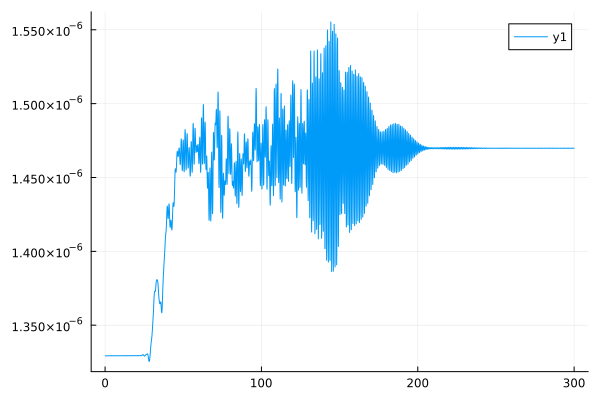

In [505]:
tss= 0.1:0.1:300
E_x = [E(ti)[1] for ti in tss]
#E_y = [E(ti)[2] for ti in tss]
#E_z = [E(ti)[3] for ti in tss]
plot(tss,E_x)
#plot!(tss,E_y)
#plot!(tss,E_z)

In [559]:
E_dtJ_func(t,r)= E_dtJ(;r=r,t=t)*ke/(c^2*h) ### The division by h is because the current is un units of (gamma e /h)
E_n_func(t,r) = E_n(;r=r,t=t)*ke/h

tss= 0.1:0.1:300
xs = 1:1:200



E1t_x = [E_dtJ_func(ti,[5,0,10*L_s])[1] for ti in tss]
#E1t_y = [E_dtJ_func(ti,[5,0,10])[2] for ti in tss]
#E1t_z = [E_dtJ_func(ti,[5,0,10])[3] for ti in tss]
E1x_x = [E_dtJ_func(300,[5,0,x])[1] for x in xs]



###E1t_x = [E_dtJ_func(ti,[5,0,10])[1] for ti in tss]
##E1t_y = [E_dtJ_func(ti,[5,0,10])[2] for ti in tss]
##E1t_z = [E_dtJ_func(ti,[5,0,10])[3] for ti in tss]

E2t_x = [E_n_func(ti,[5,0,10*L_s])[1] for ti in tss]
# E2t_y = [E_n_func(ti,[5,0,10])[2] for ti in tss]
# E2t_z = [E_n_func(ti,[5,0,10])[3] for ti in tss] ;
E2x_x = [E_n_func(300,[5,0,x])[1] for x in xs] ;

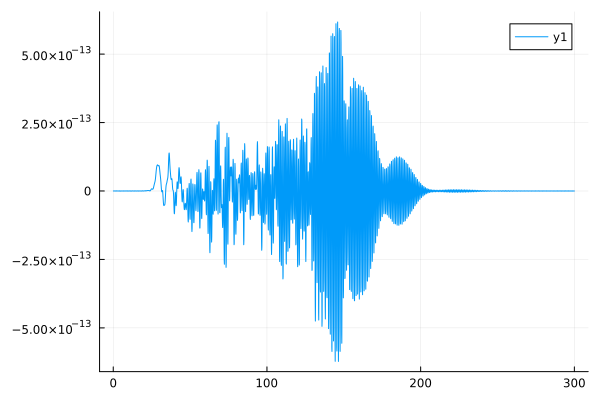

In [560]:
plot(tss,E1t_x)
#plot(tss,E1t_y)
#plot!(tss,E1t_z)

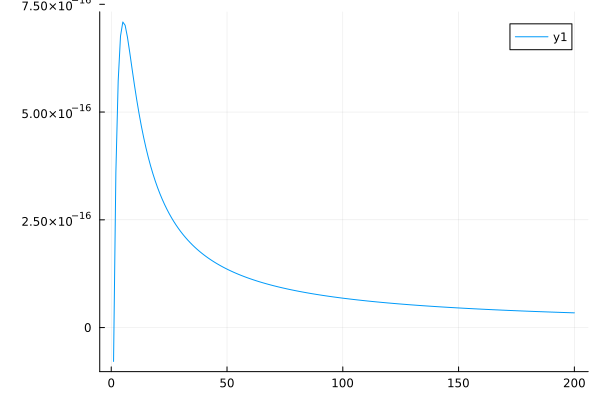

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/bZEEj/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/bZEEj/src/ticks.jl:191


In [562]:
plot(xs,E1x_x)
#plot(xs, x -> 1/x)

In [599]:
plot(tss,E2t_x)
#plot!(tss,E2t_y)
#plot!(tss,E2t_z)

[tss... ; E2t_x... ]
#writedlm(cc_f, transpose(vcat(t,obs["curr"]...) ), ' ' )

transpose(vcat([tss], [E2t_x]))

1×2 transpose(::Vector{AbstractVector{Float64}}) with eltype Transpose{Float64}:
 [0.1 0.2 … 299.9 300.0]  [8.11206e-10 8.11206e-10 … 8.1179e-10 8.1179e-10]

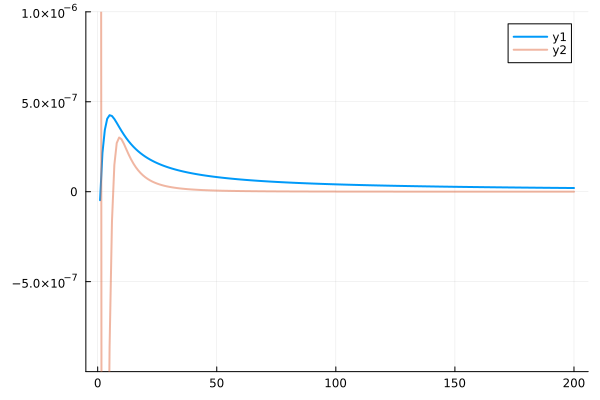

In [580]:
plot(xs,E1x_x*6e8,linewidth=2)
plot!(xs,E2x_x,ylim=(-1e-6,1e-6),linewidth=2,alpha=0.5)

In [602]:

Ecden_f = open("./data/Ecden_$(name1)_jl.txt", "w+") 
Edtj_f = open("./data/Edtj_$(name1)_jl.txt", "w+") 
writedlm(cden_f, transpose(vcat([tss], [E1t_x])), ' ' )
writedlm(Edtj_f, transpose(vcat([tss], [E2t_x])), ' ' )
close(Ecden_f)
close(Edtj_f)

LoadError: SystemError: opening file "./data/Ecden_Ni_soc_jl.txt": No such file or directory